In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [3]:
from june import World 
from june.demography.geography import Geography
from june.demography import Demography
from june.interaction import Interaction
from june.infection import Infection, HealthIndexGenerator, InfectionSelector
from june.infection.transmission import TransmissionConstant
from june.groups import Hospitals, Schools, Companies, Households, CareHomes, Cemeteries, Universities
from june.groups.leisure import generate_leisure_for_config, Cinemas, Pubs, Groceries
from june.simulator import Simulator
from june.infection_seed import InfectionSeed
from june.policy import Policy, Policies
from june import paths
from june.hdf5_savers import load_geography_from_hdf5
from june.logger.read_logger import ReadLogger
from june.world import generate_world_from_geography
from june.hdf5_savers import generate_world_from_hdf5

No --data argument given - defaulting to:
/home/florpi/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/JUNE/configs


# Initialize world

To initialize a certain world, we need to add the different components we want to have in it. First we specify what super areas (msoa) we want to create. We have included these ones, because they are known to contain hospitals, schools, care homes, and companies.

After creating the geography, we create the different components the worlds need to have such as care homes, companies ...

In [4]:
CONFIG_PATH = paths.configs_path / "config_example.yaml"

In [5]:
%%time 

geography = Geography.from_file(
        {
            "super_area": [
                "E02003282",
                "E02001720",
                "E02002560",
                "E02002559",
                "E02004314",
            ]
        }
)

geography.hospitals = Hospitals.for_geography(geography)
geography.schools = Schools.for_geography(geography)
geography.companies = Companies.for_geography(geography)
geography.care_homes = CareHomes.for_geography(geography)
geography.universities = Universities.for_super_areas(geography.super_areas)
world = generate_world_from_geography(geography, include_households=True, include_commute=True)

2020-08-21 17:58:49,487 - june.demography.geography - INFO - There are 129 areas and 5 super_areas in the world.
2020-08-21 17:58:49,492 - june.groups.hospital - INFO - There are 1 hospitals in this geography.
2020-08-21 17:58:49,553 - june.groups.school - INFO - There are 19 schools in this geography.
2020-08-21 17:58:49,583 - june.groups.school - INFO - No school for the age 0 in this world.
2020-08-21 17:58:49,587 - june.groups.school - INFO - No school for the age 1 in this world.
2020-08-21 17:58:49,592 - june.groups.school - INFO - No school for the age 2 in this world.
2020-08-21 17:58:49,870 - june.groups.carehome - INFO - There are 9 care_homes in this geography.
2020-08-21 17:58:58,521 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.
2020-08-21 17:59:02,242 - june.distributors.worker_distributor - INFO - There are 0 who had to be told to stay real
CPU times: user 31.3 s, sys: 892 ms, total: 32.2 s
Wall time: 32.2 s


## Commute, travel and leisure

In [6]:
world.pubs = Pubs.for_geography(geography)
world.cinemas = Cinemas.for_geography(geography)
world.groceries = Groceries.for_geography(geography)
leisure = generate_leisure_for_config(world, config_filename=CONFIG_PATH)
leisure.distribute_social_venues_to_households(world.households, super_areas=world.super_areas) # this assigns possible social venues to people.

2020-08-21 17:59:21,719 - june.groups.leisure.leisure - INFO - Distributing social venues to households
2020-08-21 17:59:21,719 - june.groups.leisure.leisure - INFO - Distributed in 0 of 16223 households.


We are also going to need some cemeteries...geography.cemeteries = Cemeteries()


In [7]:
world.cemeteries = Cemeteries()

In [8]:
len(world.people)

46784

### If it took a long time to run the previous commands, it might be a good idea to save the world to reuse it later.

In [9]:
world.to_hdf5("world.hdf5")

loading schools from hdf5


If we would like to load the world we saved, we just do

In [10]:
world = generate_world_from_hdf5("world.hdf5")

loading world data ...
loading companies from hdf5 .
loading households from hdf5 .
loading population from hdf5 .
restoring world...
.restoring population from hdf5 .
restoring households from hdf5 .
restoring care homes...
restoring commute...
restoring companies from hdf5 .done


In [11]:
# and regenerate leisure in case we load it externally
leisure = generate_leisure_for_config(world, CONFIG_PATH)

you have now a beautiful pre-pandemic world. 

# Adding the infection

The module in charge of infecting people is called the ``InfectionSelector``, which gives people a transmission time profile and a symptoms trajectory based on their age and sex (through the health index generator)

In [12]:
health_index_generator = HealthIndexGenerator.from_file(asymptomatic_ratio=0.2)
selector = InfectionSelector.from_file(
        health_index_generator=health_index_generator,
        transmission_config_path=paths.configs_path / 'defaults/transmission/XNExp.yaml'
)

In [13]:
selector.health_index_generator.asymptomatic_ratio

0.2

# Adding the interaction

In [14]:
interaction = Interaction.from_file()

Beta are the intensities of the interaction taking place at the different groups

In [15]:
interaction.beta

{'box': 1,
 'pub': 0.1,
 'grocery': 0.1,
 'cinema': 0.1,
 'commute_unit': 1.0,
 'commute_city_unit': 1.0,
 'hospital': 1.0,
 'care_home': 1.0,
 'company': 0.1,
 'school': 0.1,
 'household': 0.2,
 'university': 0.01}

to modify these, simply do

In [16]:
for key in interaction.beta.keys():
    interaction.beta[key] *= 1.5

In [17]:
interaction.beta

{'box': 1.5,
 'pub': 0.15000000000000002,
 'grocery': 0.15000000000000002,
 'cinema': 0.15000000000000002,
 'commute_unit': 1.5,
 'commute_city_unit': 1.5,
 'hospital': 1.5,
 'care_home': 1.5,
 'company': 0.15000000000000002,
 'school': 0.15000000000000002,
 'household': 0.30000000000000004,
 'university': 0.015}

moreover this interaction module uses contact matrices, that are different for different groups. These contact matrices shouldnt be modified for now. However they are a combination of conversational contact matrices, and physical contact matrices (see the BBC pandemic paper, from where these matrices are extracted https://www.medrxiv.org/content/10.1101/2020.02.16.20023754v2)

There is a parameter, ``alpha`` ($\alpha$), that combines these two matrices in the following way,


$\beta M \left(1 + (\alpha -1) \right) P$

where $\beta$ is the intensity of the interaction, and $P$ the physical contact matrix. A larger $\alpha$ produces more physical contacts. It is an overall number, non dependent of the particular group.


In [18]:
interaction.alpha_physical

2.0

# Seed the disease

There are two options implemented in the seed at the moment, either you specify the number of cases and these are then homogeneously distributed by population to the different areas, or you use UK data on cases per region. For now use the first case.

In [19]:
infection_seed = InfectionSeed(
    world.super_areas, selector,
)

In [20]:
n_cases = 5
infection_seed.unleash_virus(n_cases) # play around with the initial number of cases

# Set policies

In [21]:
policies = Policies.from_file()

In [22]:
policies

# Run the simulation

The simulator is the main module in charge of running the simulation. It coordinates the ``ActivityManager`` which is responsible of allocating people to the right groups given the current timestep, it updates the health status of the population, and it runs the interaction over the different groups. All of these modules can be modified by policies at any given time.

Since the timer configuration is a bit cumbersome, it is read from the config file at ``configs/config_example.yaml``

In [23]:
simulator = Simulator.from_file(
    world=world,
    infection_selector=selector,
    interaction=interaction, 
    config_filename = CONFIG_PATH,
    leisure = leisure,
    policies = policies
)

In [24]:
%%time
simulator.run()

2020-08-21 17:59:40,128 - june.simulator - INFO - Starting group_dynamics for 210 days at day 0
2020-08-21 17:59:40,129 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 210 days
2020-08-21 17:59:41,271 - june.simulator - INFO - Date = 2020-03-01 00:00:00, number of deaths =  0, number of infected = 5
2020-08-21 17:59:41,761 - june.simulator - INFO - Date = 2020-03-01 04:00:00, number of deaths =  0, number of infected = 5
2020-08-21 17:59:42,202 - june.simulator - INFO - Date = 2020-03-01 08:00:00, number of deaths =  0, number of infected = 5
2020-08-21 17:59:42,445 - june.simulator - INFO - Date = 2020-03-01 12:00:00, number of deaths =  0, number of infected = 5
2020-08-21 17:59:42,747 - june.simulator - INFO - Date = 2020-03-02 00:00:00, number of deaths =  0, number of infected = 5
2020-08-21 17:59:43,003 - june.simulator - INFO - Date = 2020-03-02 01:00:00, number of deaths =  0, number of infected = 5
2020-08-21 17:59:43,221 - june.simulator - INFO - Date =

2020-08-21 17:59:59,862 - june.simulator - INFO - Date = 2020-03-14 08:00:00, number of deaths =  0, number of infected = 751
2020-08-21 18:00:00,076 - june.simulator - INFO - Date = 2020-03-14 12:00:00, number of deaths =  0, number of infected = 771
2020-08-21 18:00:00,444 - june.simulator - INFO - Date = 2020-03-15 00:00:00, number of deaths =  0, number of infected = 825
2020-08-21 18:00:00,861 - june.simulator - INFO - Date = 2020-03-15 04:00:00, number of deaths =  0, number of infected = 856
2020-08-21 18:00:01,244 - june.simulator - INFO - Date = 2020-03-15 08:00:00, number of deaths =  0, number of infected = 880
2020-08-21 18:00:01,462 - june.simulator - INFO - Date = 2020-03-15 12:00:00, number of deaths =  0, number of infected = 904
2020-08-21 18:00:01,913 - june.simulator - INFO - Date = 2020-03-16 00:00:00, number of deaths =  0, number of infected = 948
2020-08-21 18:00:02,355 - june.simulator - INFO - Date = 2020-03-16 01:00:00, number of deaths =  0, number of infecte

2020-08-21 18:00:34,491 - june.simulator - INFO - Date = 2020-03-28 04:00:00, number of deaths =  2, number of infected = 3525
2020-08-21 18:00:35,126 - june.simulator - INFO - Date = 2020-03-28 08:00:00, number of deaths =  2, number of infected = 3553
2020-08-21 18:00:35,859 - june.simulator - INFO - Date = 2020-03-28 12:00:00, number of deaths =  2, number of infected = 3584
2020-08-21 18:00:36,510 - june.simulator - INFO - Date = 2020-03-29 00:00:00, number of deaths =  2, number of infected = 3665
2020-08-21 18:00:37,109 - june.simulator - INFO - Date = 2020-03-29 04:00:00, number of deaths =  3, number of infected = 3700
2020-08-21 18:00:37,715 - june.simulator - INFO - Date = 2020-03-29 08:00:00, number of deaths =  3, number of infected = 3727
2020-08-21 18:00:38,362 - june.simulator - INFO - Date = 2020-03-29 12:00:00, number of deaths =  3, number of infected = 3747
2020-08-21 18:00:38,999 - june.simulator - INFO - Date = 2020-03-30 00:00:00, number of deaths =  4, number of 

2020-08-21 18:01:14,859 - june.simulator - INFO - Date = 2020-04-11 00:00:00, number of deaths =  6, number of infected = 4576
2020-08-21 18:01:15,488 - june.simulator - INFO - Date = 2020-04-11 04:00:00, number of deaths =  6, number of infected = 4562
2020-08-21 18:01:16,100 - june.simulator - INFO - Date = 2020-04-11 08:00:00, number of deaths =  6, number of infected = 4546
2020-08-21 18:01:16,611 - june.simulator - INFO - Date = 2020-04-11 12:00:00, number of deaths =  6, number of infected = 4540
2020-08-21 18:01:17,230 - june.simulator - INFO - Date = 2020-04-12 00:00:00, number of deaths =  8, number of infected = 4501
2020-08-21 18:01:17,843 - june.simulator - INFO - Date = 2020-04-12 04:00:00, number of deaths =  9, number of infected = 4477
2020-08-21 18:01:18,467 - june.simulator - INFO - Date = 2020-04-12 08:00:00, number of deaths =  9, number of infected = 4463
2020-08-21 18:01:18,976 - june.simulator - INFO - Date = 2020-04-12 12:00:00, number of deaths =  9, number of 

2020-08-21 18:01:55,812 - june.simulator - INFO - Date = 2020-04-24 13:00:00, number of deaths =  16, number of infected = 3652
2020-08-21 18:01:56,443 - june.simulator - INFO - Date = 2020-04-25 00:00:00, number of deaths =  16, number of infected = 3628
2020-08-21 18:01:57,054 - june.simulator - INFO - Date = 2020-04-25 04:00:00, number of deaths =  16, number of infected = 3612
2020-08-21 18:01:57,666 - june.simulator - INFO - Date = 2020-04-25 08:00:00, number of deaths =  16, number of infected = 3611
2020-08-21 18:01:58,175 - june.simulator - INFO - Date = 2020-04-25 12:00:00, number of deaths =  16, number of infected = 3609
2020-08-21 18:01:58,806 - june.simulator - INFO - Date = 2020-04-26 00:00:00, number of deaths =  16, number of infected = 3599
2020-08-21 18:01:59,415 - june.simulator - INFO - Date = 2020-04-26 04:00:00, number of deaths =  16, number of infected = 3590
2020-08-21 18:02:00,029 - june.simulator - INFO - Date = 2020-04-26 08:00:00, number of deaths =  17, nu

2020-08-21 18:02:33,112 - june.simulator - INFO - Date = 2020-05-08 10:00:00, number of deaths =  27, number of infected = 3314
2020-08-21 18:02:33,610 - june.simulator - INFO - Date = 2020-05-08 13:00:00, number of deaths =  27, number of infected = 3307
2020-08-21 18:02:34,228 - june.simulator - INFO - Date = 2020-05-09 00:00:00, number of deaths =  28, number of infected = 3288
2020-08-21 18:02:34,832 - june.simulator - INFO - Date = 2020-05-09 04:00:00, number of deaths =  28, number of infected = 3282
2020-08-21 18:02:35,455 - june.simulator - INFO - Date = 2020-05-09 08:00:00, number of deaths =  28, number of infected = 3275
2020-08-21 18:02:35,958 - june.simulator - INFO - Date = 2020-05-09 12:00:00, number of deaths =  29, number of infected = 3277
2020-08-21 18:02:36,596 - june.simulator - INFO - Date = 2020-05-10 00:00:00, number of deaths =  29, number of infected = 3259
2020-08-21 18:02:37,202 - june.simulator - INFO - Date = 2020-05-10 04:00:00, number of deaths =  29, nu

2020-08-21 18:03:10,112 - june.simulator - INFO - Date = 2020-05-22 09:00:00, number of deaths =  34, number of infected = 2483
2020-08-21 18:03:10,733 - june.simulator - INFO - Date = 2020-05-22 10:00:00, number of deaths =  34, number of infected = 2484
2020-08-21 18:03:11,225 - june.simulator - INFO - Date = 2020-05-22 13:00:00, number of deaths =  34, number of infected = 2468
2020-08-21 18:03:11,825 - june.simulator - INFO - Date = 2020-05-23 00:00:00, number of deaths =  34, number of infected = 2431
2020-08-21 18:03:12,428 - june.simulator - INFO - Date = 2020-05-23 04:00:00, number of deaths =  34, number of infected = 2425
2020-08-21 18:03:13,027 - june.simulator - INFO - Date = 2020-05-23 08:00:00, number of deaths =  34, number of infected = 2416
2020-08-21 18:03:13,518 - june.simulator - INFO - Date = 2020-05-23 12:00:00, number of deaths =  34, number of infected = 2408
2020-08-21 18:03:14,119 - june.simulator - INFO - Date = 2020-05-24 00:00:00, number of deaths =  34, nu

2020-08-21 18:03:46,509 - june.simulator - INFO - Date = 2020-06-05 01:00:00, number of deaths =  40, number of infected = 1428
2020-08-21 18:03:47,037 - june.simulator - INFO - Date = 2020-06-05 09:00:00, number of deaths =  40, number of infected = 1401
2020-08-21 18:03:47,763 - june.simulator - INFO - Date = 2020-06-05 10:00:00, number of deaths =  40, number of infected = 1399
2020-08-21 18:03:48,268 - june.simulator - INFO - Date = 2020-06-05 13:00:00, number of deaths =  40, number of infected = 1381
2020-08-21 18:03:48,871 - june.simulator - INFO - Date = 2020-06-06 00:00:00, number of deaths =  40, number of infected = 1352
2020-08-21 18:03:49,588 - june.simulator - INFO - Date = 2020-06-06 04:00:00, number of deaths =  40, number of infected = 1343
2020-08-21 18:03:50,231 - june.simulator - INFO - Date = 2020-06-06 08:00:00, number of deaths =  41, number of infected = 1331
2020-08-21 18:03:50,694 - june.simulator - INFO - Date = 2020-06-06 12:00:00, number of deaths =  41, nu

2020-08-21 18:04:19,956 - june.simulator - INFO - Date = 2020-06-19 00:00:00, number of deaths =  45, number of infected = 647
2020-08-21 18:04:20,530 - june.simulator - INFO - Date = 2020-06-19 01:00:00, number of deaths =  45, number of infected = 641
2020-08-21 18:04:20,981 - june.simulator - INFO - Date = 2020-06-19 09:00:00, number of deaths =  45, number of infected = 631
2020-08-21 18:04:21,528 - june.simulator - INFO - Date = 2020-06-19 10:00:00, number of deaths =  45, number of infected = 630
2020-08-21 18:04:21,953 - june.simulator - INFO - Date = 2020-06-19 13:00:00, number of deaths =  45, number of infected = 622
2020-08-21 18:04:22,506 - june.simulator - INFO - Date = 2020-06-20 00:00:00, number of deaths =  45, number of infected = 605
2020-08-21 18:04:23,045 - june.simulator - INFO - Date = 2020-06-20 04:00:00, number of deaths =  45, number of infected = 602
2020-08-21 18:04:23,593 - june.simulator - INFO - Date = 2020-06-20 08:00:00, number of deaths =  45, number of

2020-08-21 18:04:52,355 - june.simulator - INFO - Date = 2020-07-02 13:00:00, number of deaths =  46, number of infected = 260
2020-08-21 18:04:52,801 - june.simulator - INFO - Date = 2020-07-03 00:00:00, number of deaths =  46, number of infected = 259
2020-08-21 18:04:53,385 - june.simulator - INFO - Date = 2020-07-03 01:00:00, number of deaths =  46, number of infected = 260
2020-08-21 18:04:53,834 - june.simulator - INFO - Date = 2020-07-03 09:00:00, number of deaths =  46, number of infected = 254
2020-08-21 18:04:54,373 - june.simulator - INFO - Date = 2020-07-03 10:00:00, number of deaths =  46, number of infected = 254
2020-08-21 18:04:54,805 - june.simulator - INFO - Date = 2020-07-03 13:00:00, number of deaths =  46, number of infected = 253
2020-08-21 18:04:55,322 - june.simulator - INFO - Date = 2020-07-04 00:00:00, number of deaths =  46, number of infected = 241
2020-08-21 18:04:55,811 - june.simulator - INFO - Date = 2020-07-04 04:00:00, number of deaths =  46, number of

2020-08-21 18:05:21,519 - june.simulator - INFO - Date = 2020-07-16 09:00:00, number of deaths =  46, number of infected = 85
2020-08-21 18:05:22,024 - june.simulator - INFO - Date = 2020-07-16 10:00:00, number of deaths =  46, number of infected = 85
2020-08-21 18:05:22,378 - june.simulator - INFO - Date = 2020-07-16 13:00:00, number of deaths =  46, number of infected = 84
2020-08-21 18:05:22,732 - june.simulator - INFO - Date = 2020-07-17 00:00:00, number of deaths =  46, number of infected = 82
2020-08-21 18:05:23,263 - june.simulator - INFO - Date = 2020-07-17 01:00:00, number of deaths =  46, number of infected = 82
2020-08-21 18:05:23,626 - june.simulator - INFO - Date = 2020-07-17 09:00:00, number of deaths =  46, number of infected = 77
2020-08-21 18:05:24,139 - june.simulator - INFO - Date = 2020-07-17 10:00:00, number of deaths =  46, number of infected = 77
2020-08-21 18:05:24,486 - june.simulator - INFO - Date = 2020-07-17 13:00:00, number of deaths =  46, number of infect

2020-08-21 18:05:50,349 - june.simulator - INFO - Date = 2020-07-30 09:00:00, number of deaths =  46, number of infected = 18
2020-08-21 18:05:50,854 - june.simulator - INFO - Date = 2020-07-30 10:00:00, number of deaths =  46, number of infected = 18
2020-08-21 18:05:51,210 - june.simulator - INFO - Date = 2020-07-30 13:00:00, number of deaths =  46, number of infected = 18
2020-08-21 18:05:51,583 - june.simulator - INFO - Date = 2020-07-31 00:00:00, number of deaths =  46, number of infected = 14
2020-08-21 18:05:52,122 - june.simulator - INFO - Date = 2020-07-31 01:00:00, number of deaths =  46, number of infected = 14
2020-08-21 18:05:52,486 - june.simulator - INFO - Date = 2020-07-31 09:00:00, number of deaths =  46, number of infected = 14
2020-08-21 18:05:53,036 - june.simulator - INFO - Date = 2020-07-31 10:00:00, number of deaths =  46, number of infected = 14
2020-08-21 18:05:53,394 - june.simulator - INFO - Date = 2020-07-31 13:00:00, number of deaths =  46, number of infect

2020-08-21 18:06:17,876 - june.simulator - INFO - Date = 2020-08-13 09:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:18,372 - june.simulator - INFO - Date = 2020-08-13 10:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:18,682 - june.simulator - INFO - Date = 2020-08-13 13:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:19,005 - june.simulator - INFO - Date = 2020-08-14 00:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:19,443 - june.simulator - INFO - Date = 2020-08-14 01:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:19,763 - june.simulator - INFO - Date = 2020-08-14 09:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:20,217 - june.simulator - INFO - Date = 2020-08-14 10:00:00, number of deaths =  46, number of infected = 1
2020-08-21 18:06:20,523 - june.simulator - INFO - Date = 2020-08-14 13:00:00, number of deaths =  46, number of infected = 1


2020-08-21 18:06:43,375 - june.simulator - INFO - Date = 2020-08-27 09:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:43,849 - june.simulator - INFO - Date = 2020-08-27 10:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:44,161 - june.simulator - INFO - Date = 2020-08-27 13:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:44,488 - june.simulator - INFO - Date = 2020-08-28 00:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:44,944 - june.simulator - INFO - Date = 2020-08-28 01:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:45,274 - june.simulator - INFO - Date = 2020-08-28 09:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:45,747 - june.simulator - INFO - Date = 2020-08-28 10:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:06:46,064 - june.simulator - INFO - Date = 2020-08-28 13:00:00, number of deaths =  46, number of infected = 0


2020-08-21 18:07:09,241 - june.simulator - INFO - Date = 2020-09-10 09:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:09,711 - june.simulator - INFO - Date = 2020-09-10 10:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:10,020 - june.simulator - INFO - Date = 2020-09-10 13:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:10,358 - june.simulator - INFO - Date = 2020-09-11 00:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:10,829 - june.simulator - INFO - Date = 2020-09-11 01:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:11,155 - june.simulator - INFO - Date = 2020-09-11 09:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:11,621 - june.simulator - INFO - Date = 2020-09-11 10:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:11,929 - june.simulator - INFO - Date = 2020-09-11 13:00:00, number of deaths =  46, number of infected = 0


2020-08-21 18:07:35,862 - june.simulator - INFO - Date = 2020-09-24 09:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:36,375 - june.simulator - INFO - Date = 2020-09-24 10:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:36,695 - june.simulator - INFO - Date = 2020-09-24 13:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:37,025 - june.simulator - INFO - Date = 2020-09-25 00:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:37,496 - june.simulator - INFO - Date = 2020-09-25 01:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:37,838 - june.simulator - INFO - Date = 2020-09-25 09:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:38,369 - june.simulator - INFO - Date = 2020-09-25 10:00:00, number of deaths =  46, number of infected = 0
2020-08-21 18:07:38,704 - june.simulator - INFO - Date = 2020-09-25 13:00:00, number of deaths =  46, number of infected = 0


While the simulation runs (and afterwards) we can launch the visualization webpage by running
```python june/visualizer.py path/to/results``` 

# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [25]:
import pandas as pd

In [26]:
read = ReadLogger()

## Hospital data and how it changed over time

In [27]:
hospitals_df = read.load_hospital_capacity()

In [28]:
hospitals_df.head(3)

,time_stamp,id,n_patients,n_patients_icu
0,2020-03-01T00:00:00.000000,0,0,0
1,2020-03-01T04:00:00.000000,0,0,0
2,2020-03-01T08:00:00.000000,0,0,0


In [29]:
hospitals_characteristics_df = read.load_hospital_characteristics()

In [30]:
hospitals_characteristics_df

,longitude,latitude,n_beds,n_icu_beds,trust_code
0,0.688477,51.5625,2115,296,RAJ


## where did infections happen?

In [31]:
loc_df = read.get_locations_infections()

In [32]:
locations_per_day = read.locations_df.groupby(pd.Grouper(freq='D')).sum()

In [33]:
all_infection_places = set(locations_per_day.location.sum())

In [34]:
def n_infections(row, infection_place):
    return sum([row.counts[i] for i, x in enumerate(row.location) if x == infection_place])


In [35]:
for infection_place in all_infection_places:
    locations_per_day[str(infection_place)] = locations_per_day.apply(
        lambda x: n_infections(x, infection_place),
        axis=1
    )

In [36]:
locations_per_day = locations_per_day.drop(columns=['location',
                                                    'counts'])

In [37]:
locations_per_day = locations_per_day.div(
    locations_per_day.sum(axis=1), axis=0
)


In [38]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

Text(0, 0.5, 'Percent of infections')

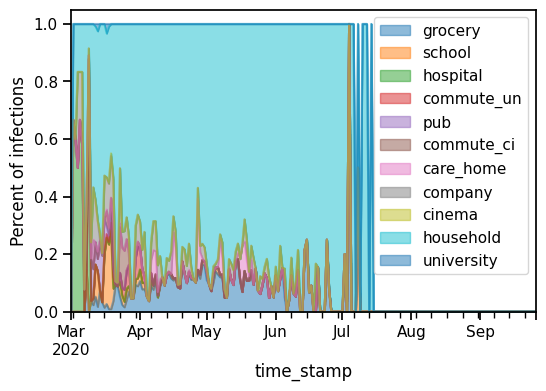

In [39]:
locations_per_day.plot.area( alpha=0.5)
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('Percent of infections')

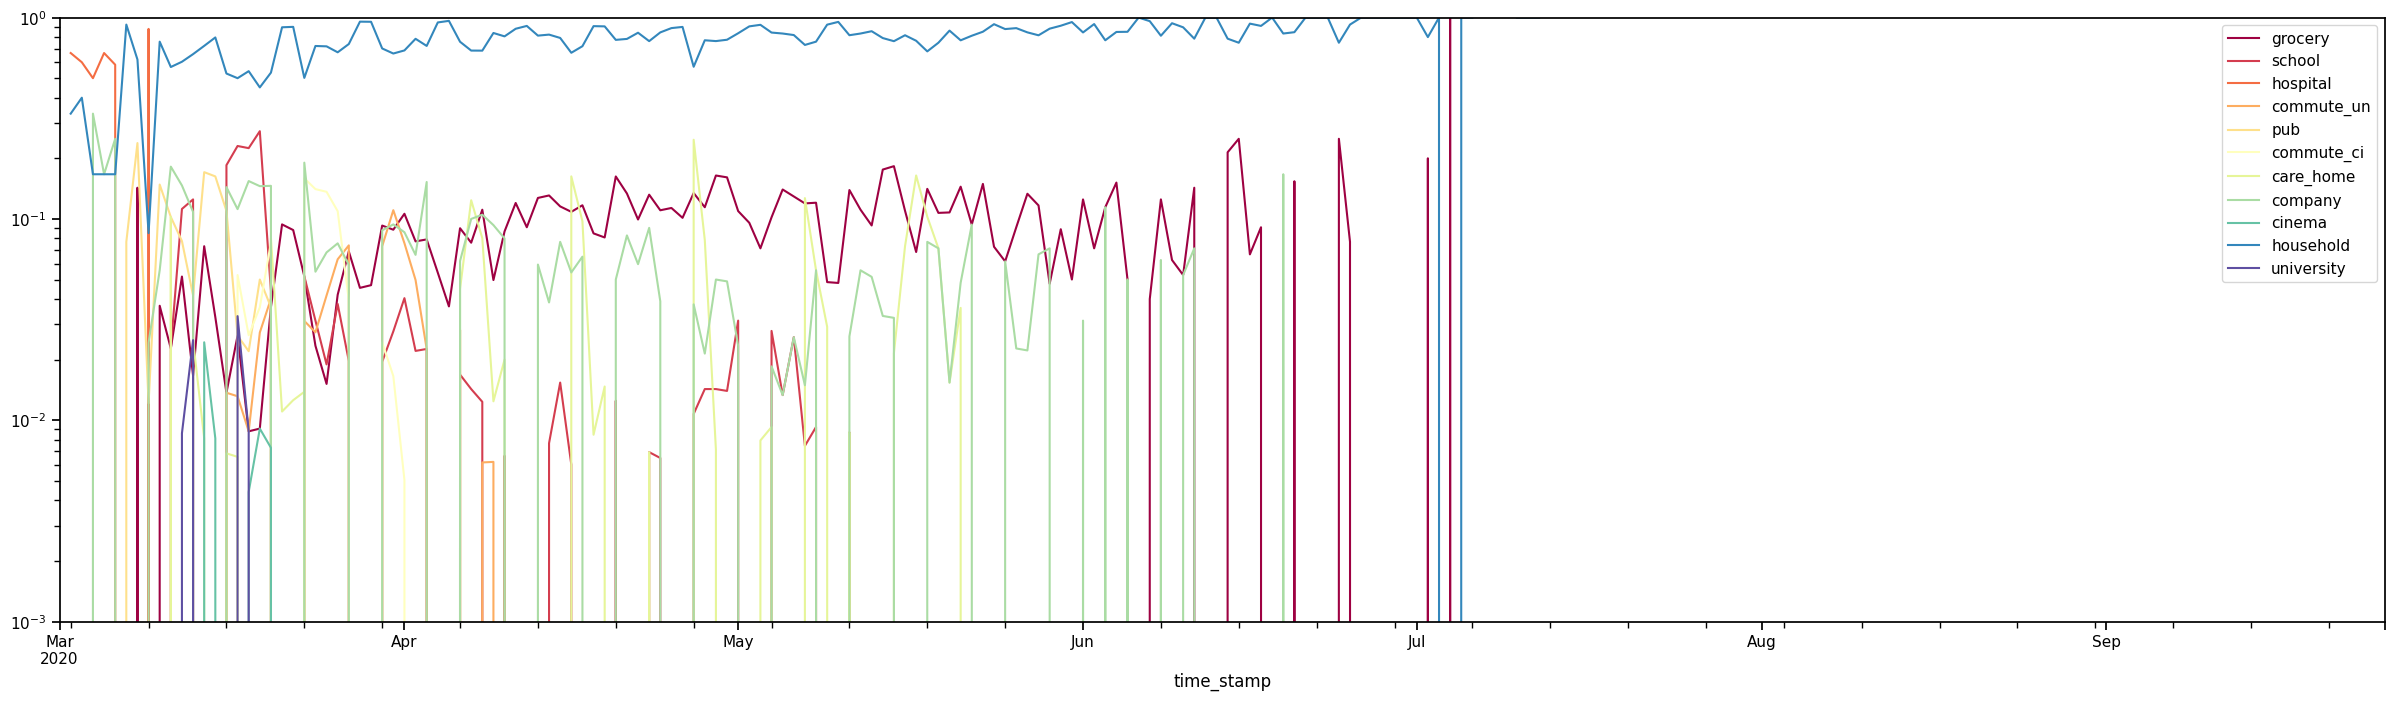

In [40]:
from matplotlib import cm
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

locations_per_day.plot(figsize=(30,8), logy=True, ylim=(1e-3, 1), cmap=cmap)

Text(0.5, 0, 'location')

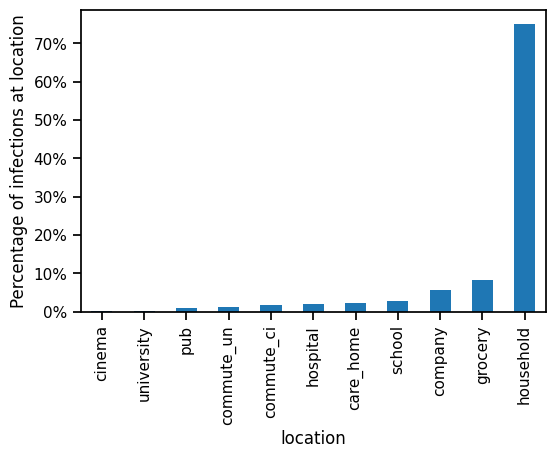

In [41]:
import matplotlib.ticker as mtick

ax = loc_df['percentage_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')
#plt.yscale('log')

## rate of infection

In [42]:
r_df = read.get_r()

/home/florpi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/florpi/.local/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'R')

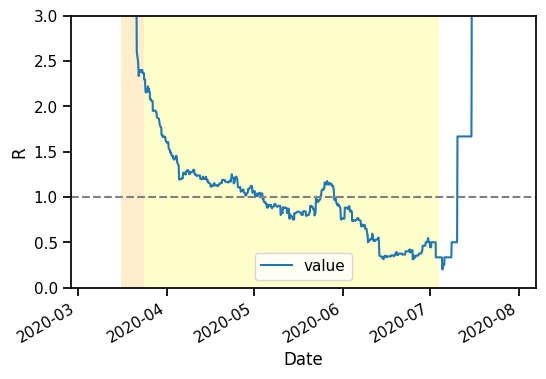

In [43]:
from june.policy import SocialDistancing
r_df.plot()
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.axhline(y=1, linestyle='dashed', color='gray')
plt.xlabel('Date')
plt.ylim(0,3)
plt.ylabel('R')

## World infection curves, and by super area

In [44]:
world_df = read.world_summary()

Text(0.5, 0, 'Date')

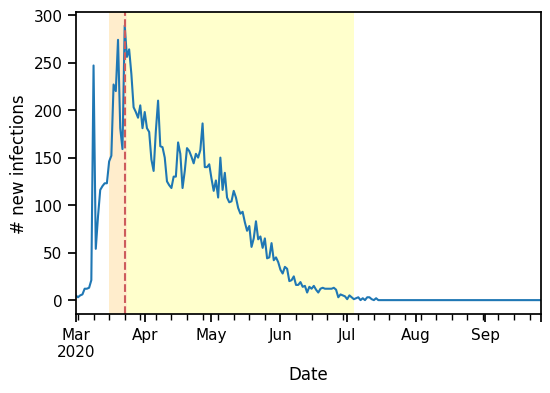

In [45]:
fig, ax = plt.subplots()
world_df['new_infections'].resample('D').sum().plot(ax=ax)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.axvline('2020-03-23',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# new infections')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

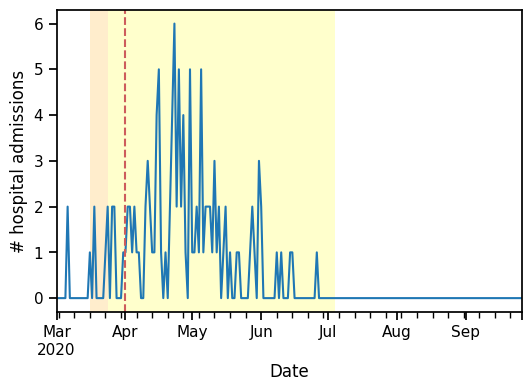

In [46]:
fig, ax = plt.subplots()
(world_df['hospital_admissions']+world_df['intensive_care_admissions']).resample('D').sum().plot(ax=ax)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.axvline('2020-04-01',
           linestyle='dashed',
           color='indianred')
ax.set_ylabel('# hospital admissions')
ax.set_xlabel('Date')

Text(0.5, 0, 'Date')

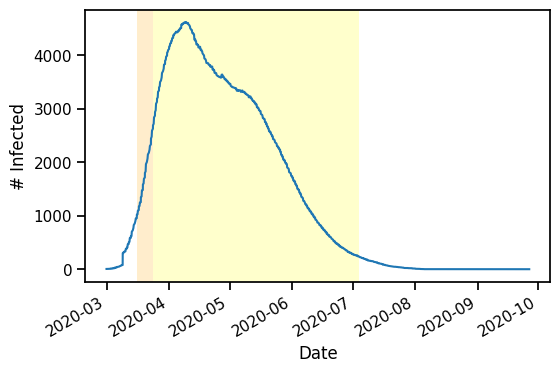

In [47]:
fig, ax = plt.subplots()
world_df['infected'].plot(ax=ax)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
ax.set_ylabel('# Infected')
ax.set_xlabel('Date')

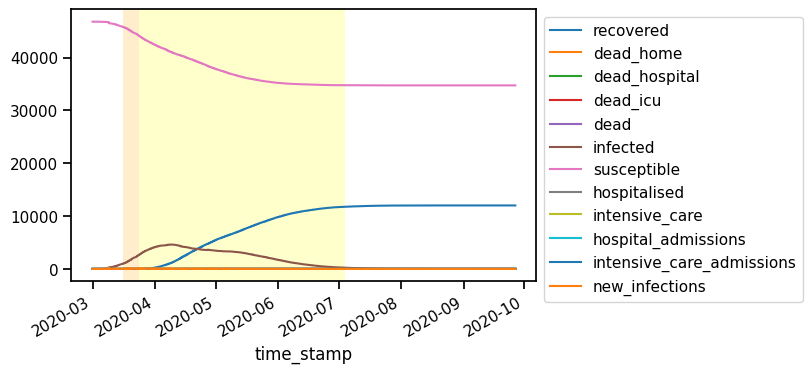

In [48]:
world_df.plot()
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


In [49]:
area_df = read.super_area_summary()

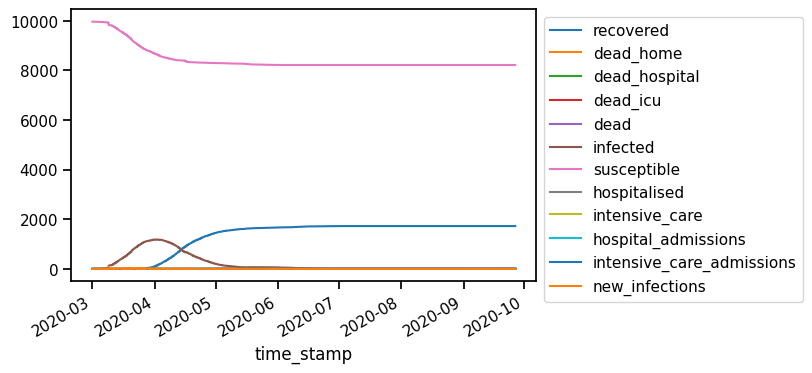

In [50]:
area_df[area_df.super_area == "E02003282"].plot()
plt.legend(bbox_to_anchor=(1,1))

## World infection curves per age group

In [51]:
ages_df = read.age_summary([0,10,20,30,40,
                  50,60,70,80,90,100])

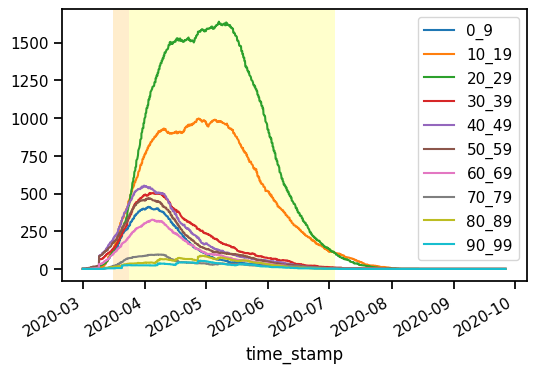

In [52]:
for name, group in ages_df.groupby('age_range'):
    group['infected'].plot(label=name)
colors = ["yellow", "orange"]
for policy in policies.policies:
    if isinstance(policy, SocialDistancing):
        plt.axvspan(policy.start_time, 
                policy.end_time,
                facecolor=colors.pop(), alpha=0.2)
plt.legend(bbox_to_anchor=(1,1))


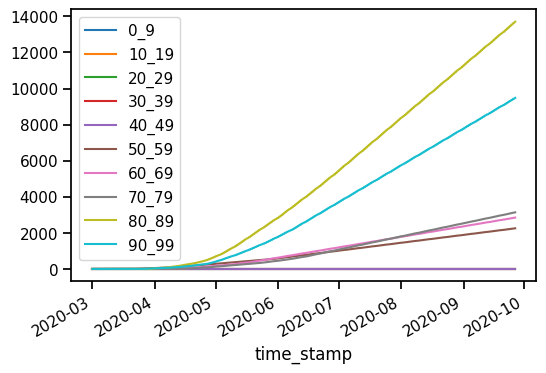

In [53]:
for name, group in ages_df.groupby('age_range'):
    group['dead'].cumsum().plot(label=name)
plt.legend()

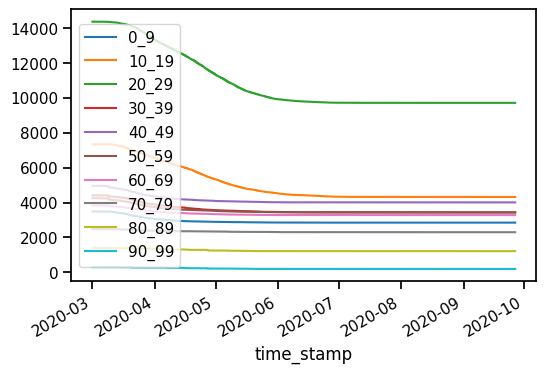

In [54]:
for name, group in ages_df.groupby('age_range'):
    group['susceptible'].plot(label=name)
plt.legend()

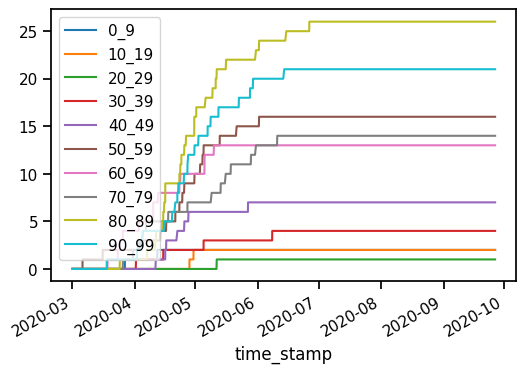

In [55]:
for name, group in ages_df.groupby('age_range'):
    group['hospital_admissions'].cumsum().plot(label=name)
plt.legend()

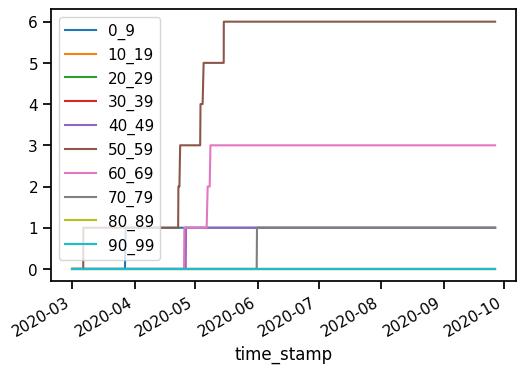

In [56]:
for name, group in ages_df.groupby('age_range'):
    group['intensive_care_admissions'].cumsum().plot(label=name)
plt.legend()

## Draw some of the symptoms trajectories

In [57]:
random_trajectories = read.draw_symptom_trajectories(window_length=600,
                                        n_people=10)

In [58]:
from june.infection import SymptomTag

In [59]:
symptoms_values = [tag.value for tag in SymptomTag]
symptoms_names = [tag.name for tag in SymptomTag]


Text(0.5, 0, 'Date')

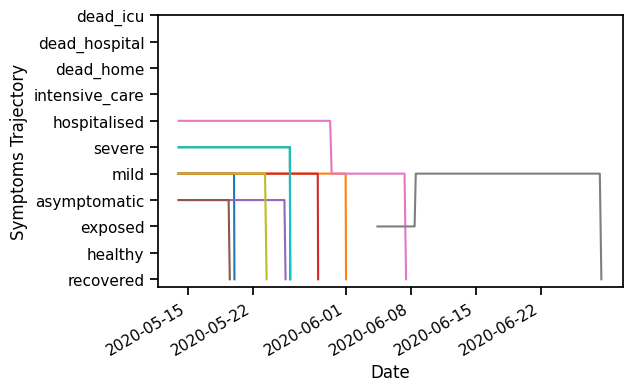

In [60]:
for df_person in random_trajectories:
    df_person['symptoms'].plot()
plt.ylabel('Symptoms Trajectory')
_ = plt.yticks(symptoms_values, symptoms_names)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

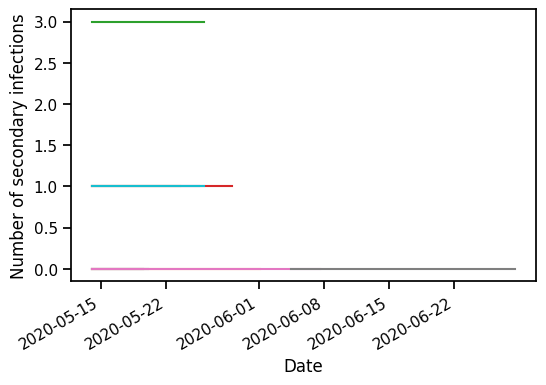

In [61]:
for df_person in random_trajectories:
    df_person['n_secondary_infections'].plot()
plt.ylabel('Number of secondary infections')

plt.xlabel('Date')

In [62]:
person.primary_activity.group.spec

NameError: name 'person' is not defined